In [1]:
import warnings
from sklearn import set_config 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, \
                    accuracy_score, f1_score, precision_score, recall_score
                    
import matplotlib.pyplot as plt
                    
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pandas.plotting import scatter_matrix


from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

# **Modelos de aprendizaje automático para estimar el uso de Bicing en una estación**

Este notebook contiene el código utilizado para el proyecto de APA ***Modelos de aprendizaje automático para estimar el uso
de Bicing en una estación*** realizado por **Nicolas Llorens** y **Fernando Guirao**.

## **Estudio preliminar del dataset**

In [2]:
data = pd.read_csv('dataset_generation/dataset.csv')

data.sample(5)

,hour,day,month,year,week_day,working_day,class_day,exits,temperature,a_temperature,humidity,precipitation,rain,wind_speed,demand_satisfied
24314,2,11,10,2023,2,1,1,0,16.4,17.8,96.6,0.0,0.0,4.8,1.0
15328,16,1,10,2022,5,0,3,1,23.0,21.7,52.5,0.0,0.0,15.0,0.0
22909,13,13,8,2023,6,0,3,2,28.8,31.6,64.2,0.0,0.0,12.4,1.0
8206,22,8,12,2021,2,0,3,0,7.4,2.6,52.1,0.0,0.0,16.8,0.0
11407,7,21,4,2022,3,1,1,0,11.7,10.4,91.7,0.3,0.3,10.4,1.0


### **Estadísticas descriptivas**

In [3]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
hour,25536.0,11.500000,6.922322,0.0,5.75,11.5,17.25,23.0
day,25536.0,15.712406,8.791936,1.0,8.00,16.0,23.00,31.0
month,25536.0,6.366541,3.366900,1.0,3.00,6.0,9.00,12.0
year,25536.0,2021.970865,0.810020,2021.0,2021.00,2022.0,2023.00,2023.0
week_day,25536.0,3.000000,2.000039,0.0,1.00,3.0,5.00,6.0
working_day,25536.0,0.683271,0.465210,0.0,0.00,1.0,1.00,1.0
class_day,25536.0,2.188910,0.931420,1.0,1.00,3.0,3.00,3.0
exits,25536.0,2.257206,3.678230,0.0,0.00,1.0,3.00,42.0
temperature,25536.0,16.985589,7.073900,-1.6,11.60,17.0,22.50,36.8
a_temperature,25536.0,16.598367,8.969706,-6.1,9.50,16.3,24.10,40.3


### **Tratamiento de valores faltantes**

In [4]:
# Contamos los valores faltantes en la columna 'demand_satisfied'
missing_values_count = data['demand_satisfied'].isna().sum()

missing_values_count

# Eliminamos los registros donde 'demand_satisfied' es NaN
data = data.dropna(subset=['demand_satisfied'])

718

### **Distribución de las variables**

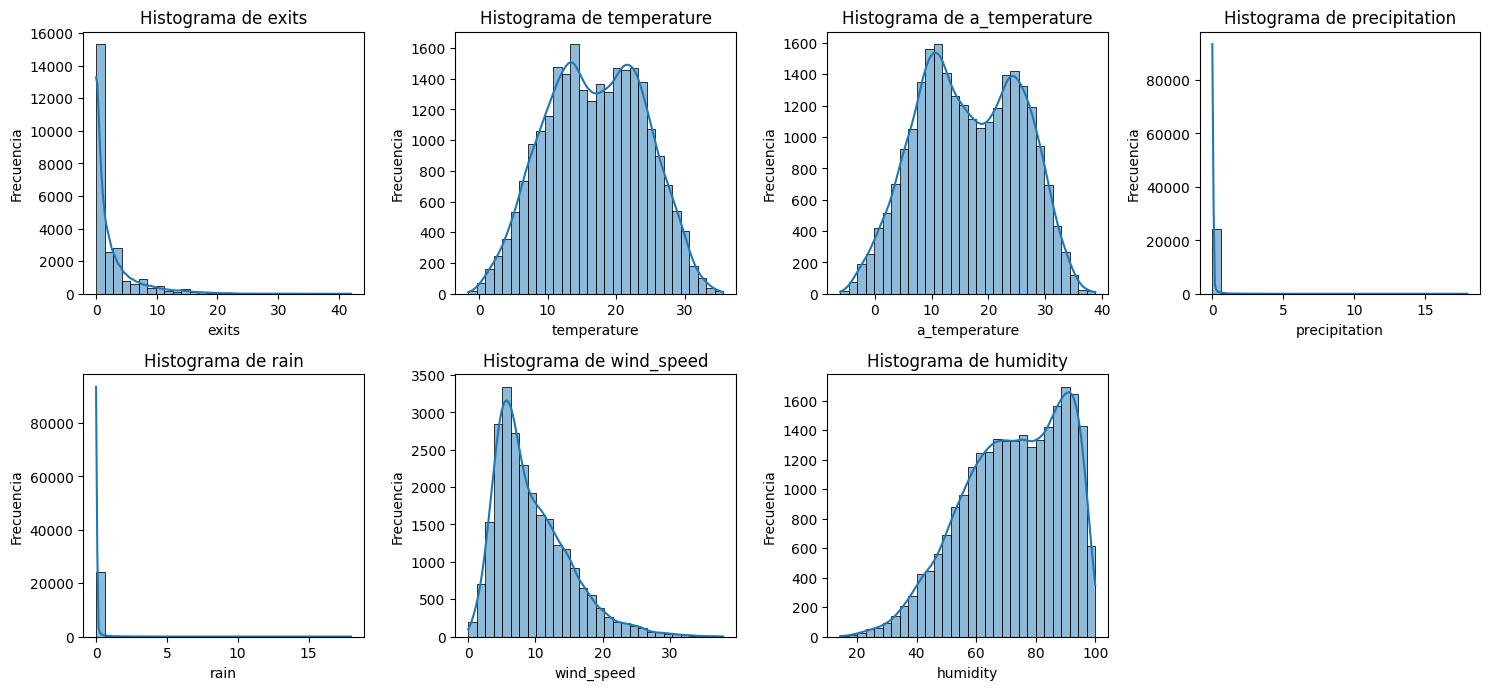

In [5]:
# Lista de variables numéricas
numeric_vars = ["exits", "temperature", "a_temperature", "precipitation", "rain", "wind_speed", "humidity"]

# Visualización de histogramas para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show();

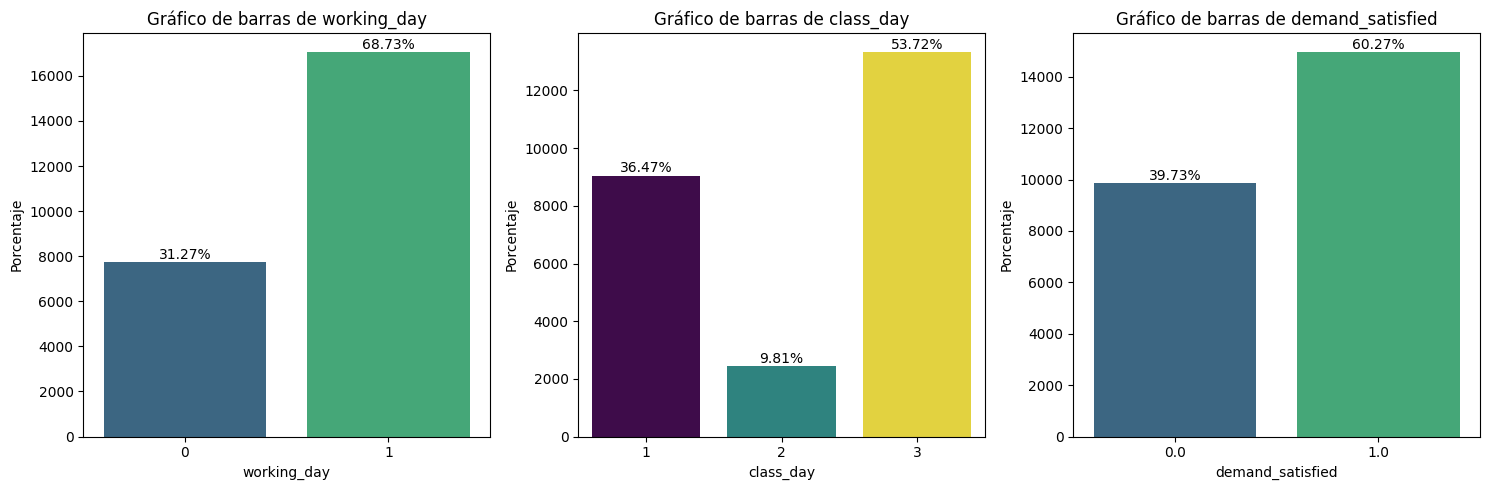

In [6]:
# Defining the list of categorical variables
categorical_vars = ['working_day', 'class_day', 'demand_satisfied']

# Plotting bar charts for categorical variables with percentages
plt.figure(figsize=(15, 5))

for i, var in enumerate(categorical_vars):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=var, data=data, hue=var, legend=False, palette='viridis')
    plt.title(f'Gráfico de barras de {var}')
    plt.xlabel(var)
    plt.ylabel('Porcentaje')

    # Calculate the percentages and display them on the bars
    total = len(data[var])  # Total number of records for normalization
    for p in plt.gca().patches:
        height = p.get_height()  # Get the height of each bar
        # Put the annotation on the bar
        plt.gca().text(p.get_x() + p.get_width() / 2, height + 2, '{:1.2f}%'.format((height / total) * 100),
                       ha="center", va='bottom')

plt.tight_layout()
plt.show();


### **Realción de la variable objetivo con el resto de variables**

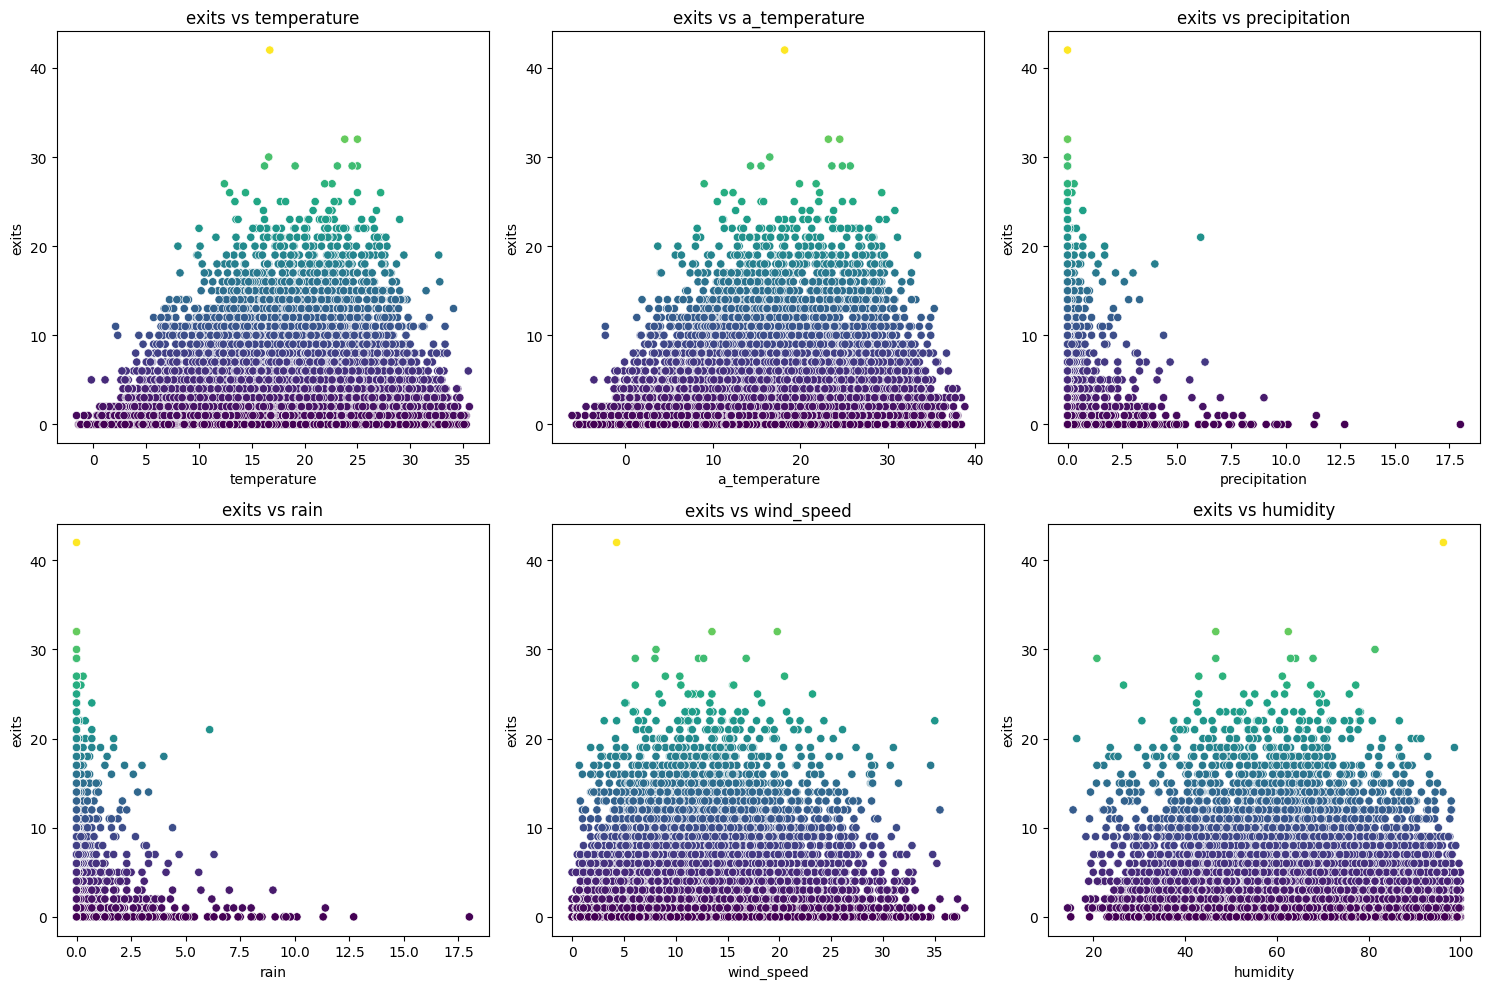

In [7]:
numeric_vars_without_exits = ["temperature", "a_temperature", "precipitation", "rain", "wind_speed", "humidity"]

# Gráficos de dispersión para variables numéricas
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_vars_without_exits, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=data, x=var, y="exits", hue='exits', legend=False, palette="viridis")
    plt.title(f'exits vs {var}')

plt.tight_layout()
plt.show();

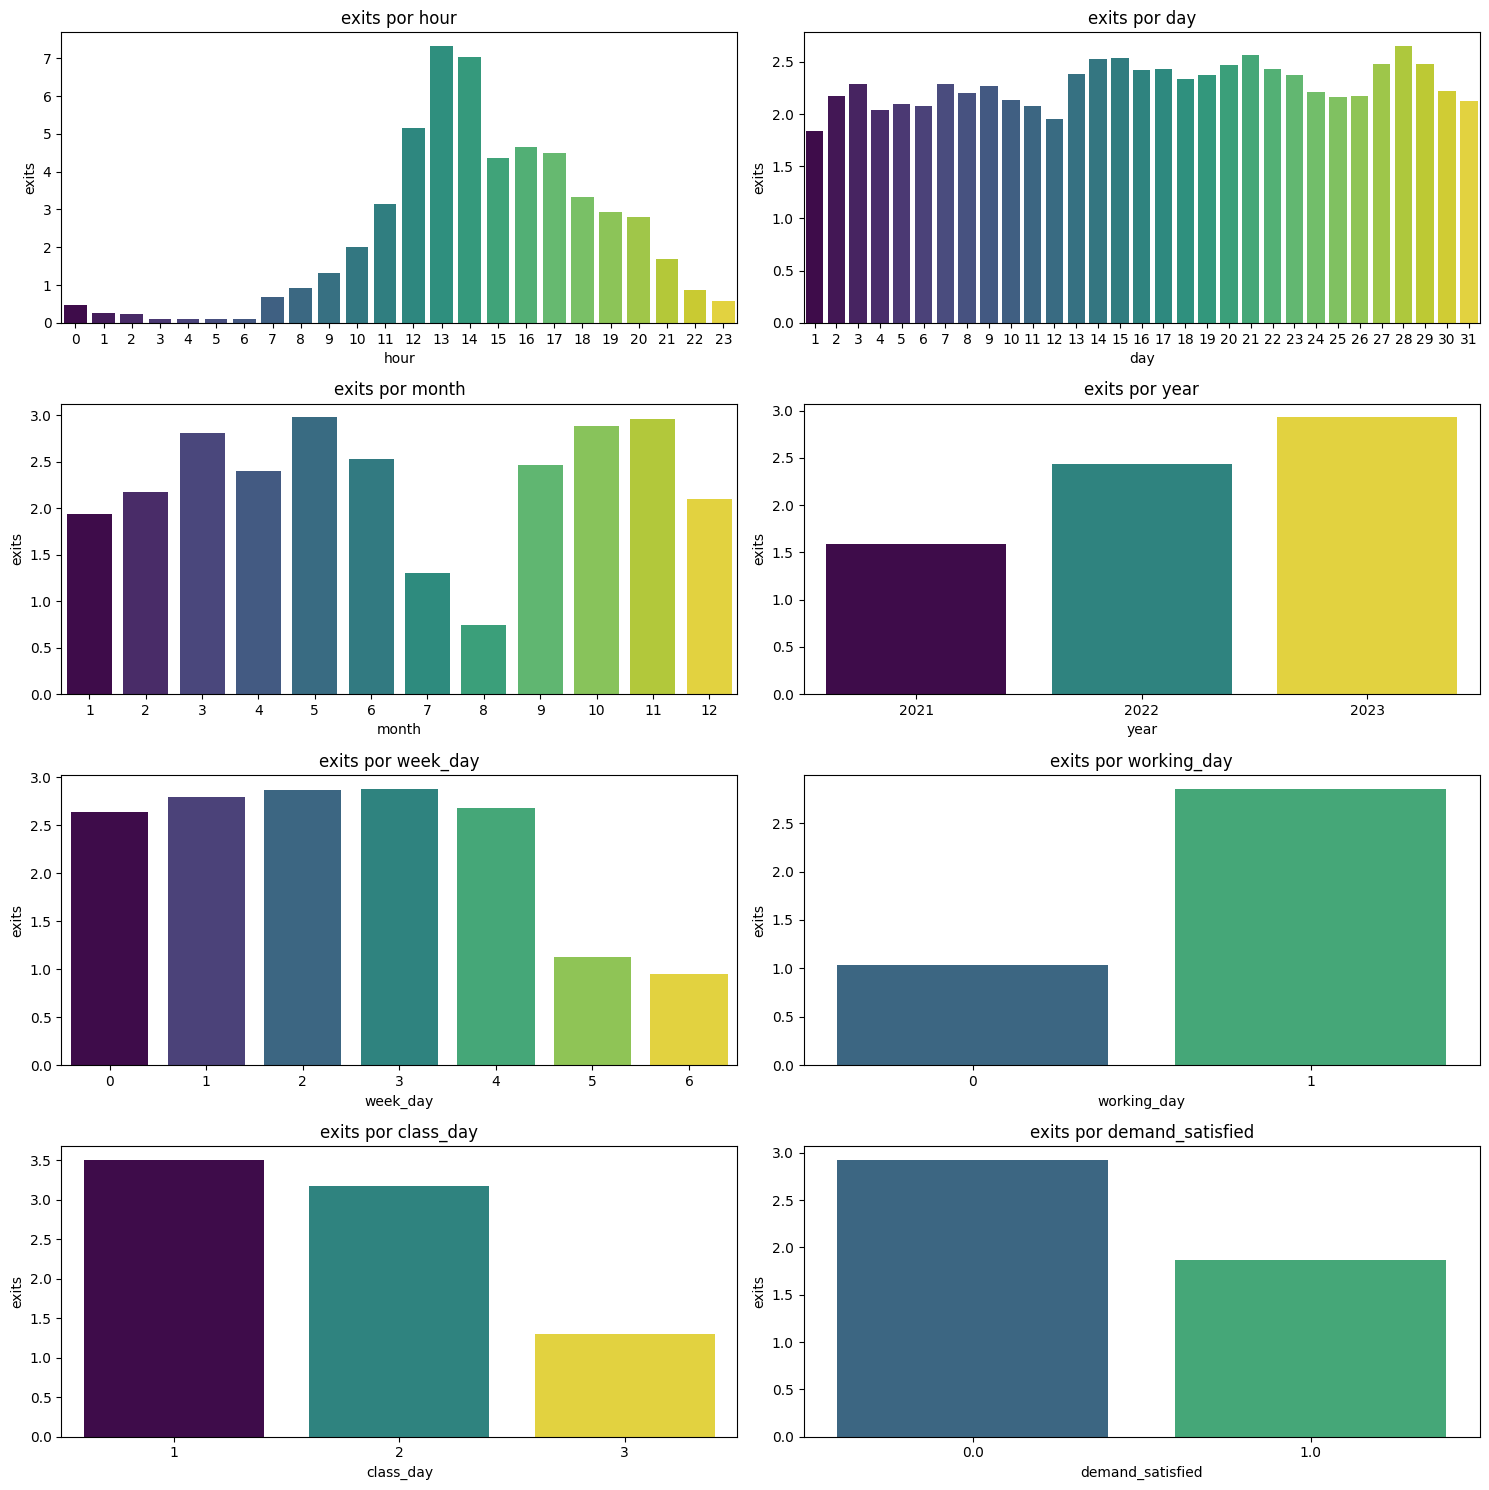

In [8]:
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day", "demand_satisfied"]

plt.figure(figsize=(15, 15))
for i, var in enumerate(categorical_vars_selected, 1):
    plt.subplot(4, 2, i)
    sns.barplot(data=data, x=var, y="exits", errorbar=None,  hue=var, legend=False, palette="viridis") 
    plt.title(f'exits por {var}')

plt.tight_layout()
plt.show();

(<Figure size 1000x800 with 1 Axes>, <Axes: >)

<Axes: >

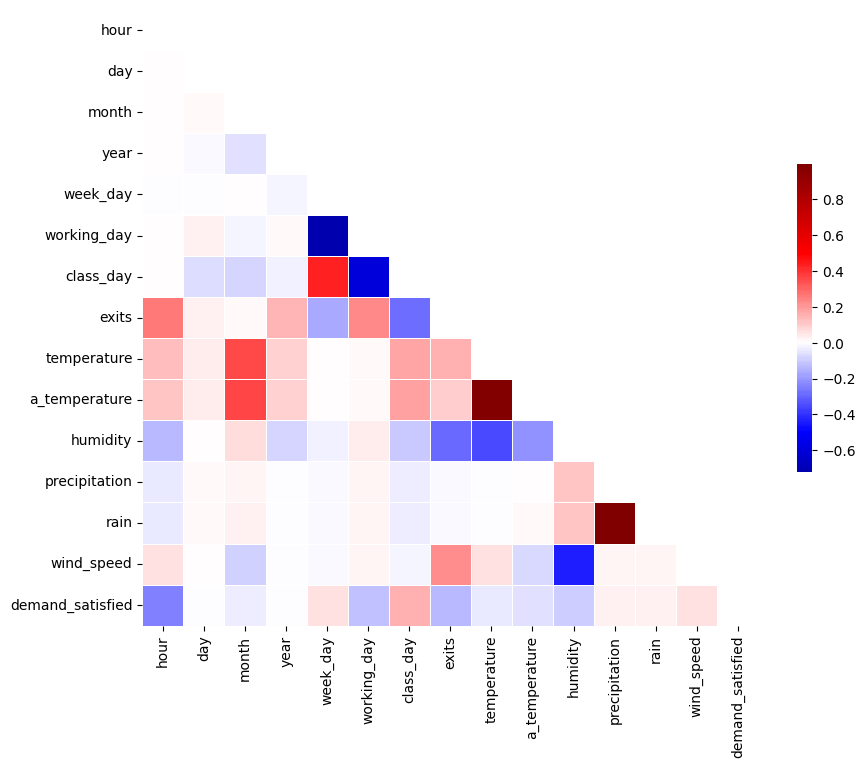

In [9]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

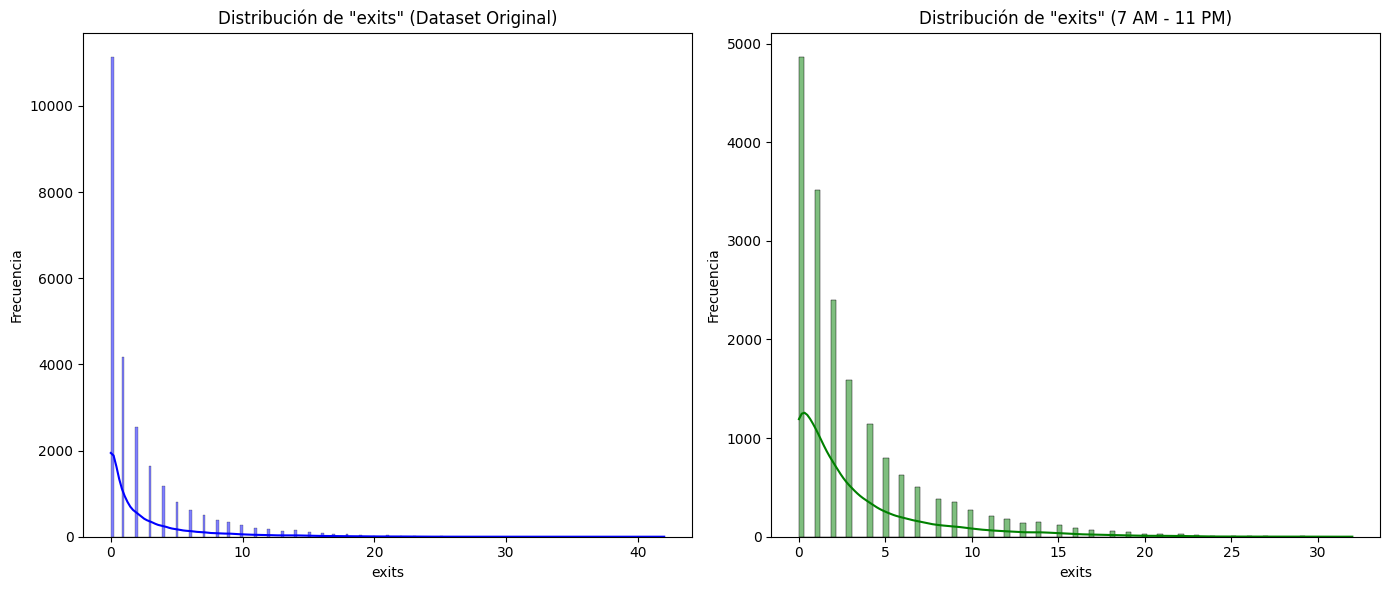

In [10]:
# Creating a copy of the dataset that only contains records between 7 AM and 11 PM (hours 7 to 23)
filtered_data = data[(data['hour'] >= 7) & (data['hour'] <= 23)]

# Plotting the distribution of 'exits' for the original and filtered datasets
plt.figure(figsize=(14, 6))

# Original dataset
plt.subplot(1, 2, 1)
sns.histplot(data['exits'], kde=True, color='blue')
plt.title('Distribución de "exits" (Dataset Original)')
plt.xlabel('exits')
plt.ylabel('Frecuencia')

# Filtered dataset
plt.subplot(1, 2, 2)
sns.histplot(filtered_data['exits'], kde=True, color='green')
plt.title('Distribución de "exits" (7 AM - 11 PM)')
plt.xlabel('exits')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show();

In [130]:
from sklearn.metrics import r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Cargar el conjunto de datos
data = pd.read_csv('dataset_generation/dataset.csv')

# Creating a copy of the dataset that only contains records between 7 AM and 11 PM (hours 7 to 23)
filtered_data = data[(data['hour'] >= 7) & (data['hour'] <= 23)]
filtered_data = data[(data['year'] >= 2021)]
# filtered_data = data[(data['month'] >= 10)]
filtered_data = data[(data['month'] <= 10)]

print(filtered_data.head(5))

# Preparar los datos para la regresión (seleccionar las variables independientes y la variable objetivo)
X = filtered_data.drop(['exits', 'demand_satisfied'], axis=1)  # Solo variables numéricas
y = filtered_data['exits']

# Calcula el índice para dividir los datos en 70% para entrenamiento y 30% para prueba
# split_index = int(len(X) * 0.9)
split_index = int(len(X) - 24)

print(split_index)

# Divide los datos en conjuntos de entrenamiento y prueba según el índice calculado
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Dividir los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Define the parameter grid
# param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 5, 10],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    # 'max_features': ['auto', 'sqrt', 'log2']
# }

param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

# Create the Random Forest model
rf = RandomForestRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the model on the test set
y_pred = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)

# Print the best parameters and R2 score
print("Best parameters:", best_params)
print("R2 score:", r2)

   hour  day  month  year  week_day  working_day  class_day  exits  \
0     0    1      1  2021         4            0          3      0   
1     1    1      1  2021         4            0          3      1   
2     2    1      1  2021         4            0          3      0   
3     3    1      1  2021         4            0          3      0   
4     4    1      1  2021         4            0          3      0   

   temperature  a_temperature  humidity  precipitation  rain  wind_speed  \
0          6.4            3.6      78.9            0.0   0.0         8.2   
1          4.9            2.0      83.0            0.0   0.0         7.8   
2          4.6            1.7      84.4            0.0   0.0         7.9   
3          4.5            1.7      85.6            0.0   0.0         7.2   
4          5.4            2.9      81.0            0.0   0.0         5.8   

   demand_satisfied  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4           

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None], 'min_samples_leaf': [4],
                         'min_samples_split': [10], 'n_estimators': [300]},
             scoring='neg_mean_squared_error')

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
R2 score: 0.681328279392257


<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Valores Reales')

Text(0, 0.5, 'Predicciones')

Text(0.5, 1.0, 'Predicciones vs Valores Reales')

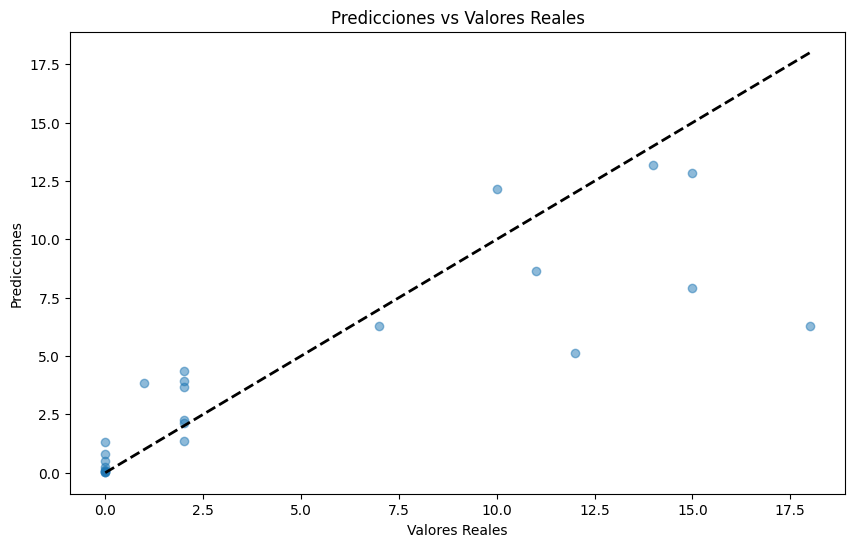

Mean Squared Error (MSE): 11.406556222592636
Mean Absolute Error (MAE): 1.9492864233893812
Explained Variance Score: 0.6963515188738945


In [129]:
import matplotlib.pyplot as plt

# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error

# Calcular y mostrar diferentes métricas de precisión
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Imprimir las métricas
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Explained Variance Score:", explained_variance)

PROBANDO PONDERACIÓN

In [41]:
from datetime import datetime

# Cargar el conjunto de datos
data = pd.read_csv('dataset_generation/dataset.csv')

# Crear una columna 'date' combinando 'year', 'month', y 'day'
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Definir el día actual para la ponderación
current_date = datetime(2024, 1, 7)

# Calcular la diferencia en días entre la fecha de cada registro y el día actual
data['days_from_current'] = (current_date - data['date']).dt.days

# Definir una función de ponderación exponencial decreciente
# Puedes ajustar 'rate' según lo rápido que quieras que disminuyan los pesos
rate = 0.005
data['weight'] = np.exp(-rate * data['days_from_current'])

# Asegúrate de que los registros futuros no reciban un peso (días negativos desde el día actual)
data['weight'] = data['weight'].where(data['days_from_current'] >= 0, 0)

# Verifica los pesos
print(data[['date', 'days_from_current', 'weight']].head())

# Creating a copy of the dataset that only contains records between 7 AM and 11 PM (hours 7 to 23)
filtered_data = data[(data['hour'] >= 7) & (data['hour'] <= 23)]

# Preparar los datos para la regresión (seleccionar las variables independientes y la variable objetivo)
X = filtered_data.drop(['exits', 'demand_satisfied', 'year'], axis=1).select_dtypes(include=np.number)  # Solo variables numéricas
y = filtered_data['exits']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Asegúrate de que los pesos solo se aplican al conjunto de entrenamiento
weights_train = data.loc[X_train.index, 'weight']

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the Random Forest model
rf = RandomForestRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train, sample_weight=weights_train)

# Get the best model and best parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the model on the test set
y_pred = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)

# Print the best parameters and R2 score
print("Best parameters:", best_params)
print("R2 score:", r2)

        date  days_from_current    weight
0 2021-01-01               1101  0.004066
1 2021-01-01               1101  0.004066
2 2021-01-01               1101  0.004066
3 2021-01-01               1101  0.004066
4 2021-01-01               1101  0.004066


KeyboardInterrupt: 

PONDERACIÓN BIEN

In [75]:
# Cargar el conjunto de datos
data = pd.read_csv('dataset_generation/dataset.csv')

# Crear la columna 'date'
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Definir el día actual para la ponderación
current_date = datetime(2023, 10, 31)

# Calcular la diferencia en días entre la fecha de cada registro y el día actual
data['days_from_current'] = (current_date - data['date']).dt.days

# Definir una función de ponderación exponencial decreciente
rate = 0.005
data['weight'] = np.exp(-rate * data['days_from_current'])
data['weight'] = data['weight'].where(data['days_from_current'] >= 0, 0)

# Filtrar los datos para incluir solo registros hasta el último día de octubre de 2023
train_data = data[data['date'] <= '2023-10-31']

# Crear el conjunto de entrenamiento
X_train = train_data.drop(['exits', 'demand_satisfied', 'date', 'days_from_current'], axis=1).select_dtypes(include=np.number)
y_train = train_data['exits']
weights_train = train_data['weight']

# Filtrar los datos para incluir solo registros del 1 de noviembre de 2023
test_data = data[data['date'] == '2023-11-01']

# Crear el conjunto de prueba
X_test = test_data.drop(['exits', 'demand_satisfied', 'date', 'days_from_current'], axis=1).select_dtypes(include=np.number)
y_test = test_data['exits']

param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

# Definir y entrenar el modelo de Random Forest
rf = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_split=10, min_samples_leaf=4)
rf.fit(X_train, y_train, sample_weight=weights_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf.predict(X_test)

# Evaluar el rendimiento
r2 = r2_score(y_test, y_pred)

r2

RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                      n_estimators=300)

0.1492754765118689

PROBANDO SVR KERNEL RBF

In [52]:
from sklearn.preprocessing import StandardScaler

categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day"]

# Cargar el conjunto de datos
data = pd.read_csv('dataset_generation/dataset.csv')

# También filtramos las horas para quedarnos solo con las de 7 a 23
filtered_data = data[(data['hour'] >= 7) & (data['hour'] <= 23)].drop('demand_satisfied', axis=1)

# Binarizar las variables categóricas y asignar el resultado al DataFrame
filtered_data = pd.get_dummies(filtered_data, columns=categorical_vars_selected, drop_first=True)

filtered_data.sample(5)

# Preparar los datos para la regresión (seleccionar las variables independientes y la variable objetivo)
X = filtered_data.drop(['exits'], axis=1).select_dtypes(include=np.number)  # Solo variables numéricas
y = filtered_data['exits']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = X.columns)

X_test = pd.DataFrame(X_test, columns=X.columns)

,exits,temperature,a_temperature,humidity,precipitation,rain,wind_speed,hour_8,hour_9,hour_10,...,year_2023,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,working_day_1,class_day_2,class_day_3
23854,2,22.2,21.0,54.7,0.0,0.0,14.4,False,False,False,...,True,False,False,True,False,False,False,True,False,False
15781,11,22.9,25.7,83.5,0.6,0.6,7.1,False,False,False,...,False,False,False,True,False,False,False,True,False,False
22123,2,27.2,32.6,82.2,0.0,0.0,4.8,False,False,False,...,True,True,False,False,False,False,False,True,False,True
16044,5,23.1,23.3,66.8,0.0,0.0,14.9,False,False,False,...,False,False,False,False,False,False,False,True,True,False
22163,3,29.5,31.1,48.8,0.0,0.0,16.9,False,False,False,...,True,False,False,True,False,False,False,True,False,True


In [56]:
from sklearn.svm import SVR

param_grid = {
    'C':10**np.linspace(-3,3,101),
    'gamma':['scale','auto'],
    'epsilon':np.linspace(0,0.01,11)
    }

svm = SVR(kernel='rbf', max_iter=50000, cache_size=2000)
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model_svm = grid_search.best_estimator_
best_score_svm = grid_search.best_score_

test_score_svm = best_model_svm.score(X_test, y_test)

print("Best Model:", best_model_svm)

print(best_score_svm, test_score_svm)

/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

KeyboardInterrupt: 

In [55]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'C': [1000.0],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.0]
}

svm = SVR(kernel='rbf', max_iter=50000, cache_size=2000)
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model_svm = grid_search.best_estimator_
best_score_svm = grid_search.best_score_

test_score_svm = best_model_svm.score(X_test, y_test)

print("Best Model:", best_model_svm)
print(best_score_svm, test_score_svm)

/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

GridSearchCV(cv=5, estimator=SVR(cache_size=2000, max_iter=50000), n_jobs=-1,
             param_grid={'C': [1000.0], 'epsilon': [0.0],
                         'gamma': ['scale', 'auto']})

Best Model: SVR(C=1000.0, cache_size=2000, epsilon=0.0, gamma='auto', max_iter=50000)
-0.004292691072770083 -0.0013155482156503862


In [59]:
import statsmodels.api as sm

from sklearn.linear_model import PoissonRegressor

# Cargar el conjunto de datos
data = pd.read_csv('dataset_generation/dataset.csv')

# Filtrar por la franja horaria y descartar la columna 'demand_satisfied'
data_filtered = data[(data['hour'] >= 7) & (data['hour'] <= 23)].drop('demand_satisfied', axis=1)

# Definir las variables independientes (X) y la variable dependiente (y)
X = data_filtered.drop('exits', axis=1)
y = data_filtered['exits']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add a constant to the independent variables
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Specify the ZIP model
zip_model = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train_const, exog_infl=X_train_const)

# Fit the model
zip_result = zip_model.fit(maxiter=1000, method='bfgs')

# Predict
y_pred_zip = zip_result.predict(X_test_const)

# Evaluate the model
r2_zip = r2_score(y_test, y_pred_zip)

         Current function value: 28.407680
         Iterations: 1
         Function evaluations: 58
         Gradient evaluations: 46


/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: operands could not be broadcast together with shapes (12661,) (5427,) 